![book header](pictures/header.png)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
# from serial import Serial # Uncomment this line if you are using the real car
from KITT_Simulator.serial_simulator import Serial # Uncomment this line if you are using the simulator

# Module 2 - Reading KITT Sensor Data

KITT relies on its sensors to drive autonomously. It is equipped with:
1. Two front-mounted distance sensors.
2. Five microphones positioned around the field to record audio signals from KITT's beacon and relay them to the soundcard after which they can be read by your PC.

This task focuses on reading data from the distance sensors to avoid obstacles and processing the microphone data from the field.

**Preparation**
- Ensure KITT is operational and properly set up.
- Reserve time for testing on a field equipped with microphones and an audio card.
- For Windows 10 users, install ASIO4ALL and use a PyAudio build compatible with ASIO.
- For Mac users, install PyAudio using Homebrew.
 
 ---

## 1. Distance Sensors

KITT’s front distance sensors use ultrasonic technology. Two SRF02 modules, mounted on the left and right sides, measure the distance to obstacles. These sensors work by emitting a 40 kHz pulse and measuring the time it takes for the echo to return. This time is converted into a distance measurement.

- Each sensor requires a minimum of 66 ms between readings, as specified in the SRF02 datasheet (available at: Files/Datasheets/srf02.pdf).
- The system is configured with a 70 ms cycle time, during which the left and right sensors take turns recording measurements.
- These measurements are stored in a buffer on KITT's microcontroller, with each new reading overwriting the previous one.

<img src="pictures/srf02-ultrasonic-sensor.jpg" alt="Ultrasonic Sensor" width="400" height="240">

To ensure you can experiment at home, we have added the status command to the simulator. Important to note is that the message from the simulator sends back a message with 999 as distance reading, as realistic measurements have not been implemented. But you should programme a way to interpret these messages at home and experiment with them during the lab sessions.

### Step 1: Status Command

You can ask KITT to capture a status command by writing "S\n" to the serial port. Then you have to read the message using "read_until", this will generate a binary message that you need to decode. KITT always ends it's message with the end-of-transmission character (0x04). The response contains 3 sections. 
1) Audio Beacon status and settings
2) PWM values for the motors
3) Sensor readings

In [4]:
serial = Serial('/dev/ttyUSB0', 115200)
serial.write(b'S\n')
status = serial.read_until(b'\x04').decode('utf-8')
print(status)
serial.close()

Canvas(height=520, width=520)

**************************
* Audio Beacon: off
* c: 0xabcdef00
* f_c: 5678
* f_b: 1234
* c_r: 1337
**************************
* PWM:
* Dir. 150
* Mot. 150
**************************
* Sensors:
* Dist. L 999 R 999
* V_batt 11.5 V
**************************



### Isolating Specific Data from KITT

If you only need specific information, such as the distance measurements, battery voltage, or version information, you can request them separately:

- **For distance measurements only**: Use the command:
  ```python
  serial_port.write(b'Sd\n')
  ```
  This returns only the left and right distance sensor values, filtering out the rest of the status report.

- **For battery voltage**: Use the command:
  ```python
  serial_port.write(b'Sv\n')
  ```
  This command returns just the battery voltage level.

- **For version information**: Use the command:
  ```python
  serial_port.write(b'V\n')
  ```
  This sends back the version details of KITT’s firmware.

### Step 2: Extracting and Isolating Distance Data

Once you have received the status information from KITT, you can extract and isolate the distance sensor readings (left and right) from the full status report.

#### Code to Extract Distance Data:

After sending the status command (`b'S\n'`), the response will contain a variety of information, including the distance measurements. Now write a Python function to extract the distance data from the status report.

1. **Send the Status Command** to receive the full status report:

In [5]:
serial = Serial('/dev/ttyUSB0', 115200)
serial.write(b'S\n')
status = serial.read_until(b'\x04')
serial.close()

Canvas(height=520, width=520)

2. **Extract the Distance Measurements**:
   The distance values are typically embedded in the `Sensors` section of the status response. You can process the `status` output to isolate just the left (`L`) and right (`R`) distance sensor values . Write a function to extract these values.

In [11]:
# Convert the status response to a string
status_str = status.decode('utf-8')

# Find the line with the distance sensor data
for line in status_str.splitlines():
    if "Dist." in line:
        # Extract the left and right distance values
        _, _, _, dist_L, _, dist_R = line.split()
        print(f"Left Distance: {dist_L}")
        print(f"Right Distance: {dist_R}")

Left Distance: 999
Right Distance: 999


## How to use distance values to model the car ? 

At first glance, ultrasonic sensors may seem useful only for detecting obstacles, but they actually serve an even more crucial purpose. To control the car autonomously, we need to understand how it responds to specific control commands (so drive and steer command). Think of it like a driver who knows how much pressing the gas pedal will accelerate the car or how much turning the steering wheel will change its direction. To understand the impact of motor forces on the car’s acceleration, we need a way to measure acceleration. However, we don’t have an accelerometer on the car—only ultrasonic sensors. Those after a bit of processing can give us distance traveled by car , and therefore we need to still convert the cars traveled distcne to speed and accelration. As a first step let breifly overview the connection displacmnet , velocity and accelration . 

The **average speed** is defined as the total distance traveled divided by the time taken:

$$
\text{Average Speed} = \frac{\text{Total Distance}}{\text{Time}}
$$

**Acceleration** is the change in speed over time:

$$
\text{Acceleration} = \frac{\text{Change in Speed}}{\text{Time}} = \frac{\Delta v}{\Delta t}
$$

When considered over very short intervals, acceleration becomes the derivative of velocity with respect to time:

$$
a(t) = \frac{dv(t)}{dt}
$$

Without diving too deep into the math, it's enough for now to know that if we can find a way to measure the distance the car travels, we can calculate its speed and acceleration. So, the key question is: how can we measure the distance traveled by the car?

If we have a known, stationary obstacle in front of KITT (like a wall), the distance measured by the sensors can be used to estimate the distance KITT has traveled. However, remember that the sensor reading doesn’t directly give the traveled distance. We also need to record the time of each measurement to calculate the distance over time.

---

Actually in Module 4, you'll get instruction to develop a car model that includes dynamics such as velocity and response to driving commands. but to build this model, you’ll need position versus time plots. Additionally, in the final challenge, you’ll need to detect obstacles in KITT’s path using the distance sensors. So it is for now imprtant to add sensor reading methods to the KITT class from Module 1. The collected data should be stored in a format that is easy to access and use later.





**Tasks**

Using the previously explained commands, have KITT transmit its various pieces of information. You can do this by adding a `read_sensors` method to the KITT class. Assign a key to show the distances measured. Display all the received data in an organized way in the terminal. (?? @Mano isn't it a task by itself? shouold we use the simulator for that?)

In [7]:
## (@Mano @Mehrdad shall we add the kitt class here again with the new methods and ask them to complete it
# lets also add an example to test it with the gui, have the car moving with keyboard and 
# then plot the measure distance vs time)

## @Mano @Mehrdad shall we add a block of code (placeholder) for each task so that they can complete it?


# I would suggest maybe a small automatic code ? Not with keyboard neccarily ? I will talk with @Mano about this

**Task 1: Static measurements** 


**step 1** Perform measurements with the vehicle at stand-still. 





In [8]:
## Perform just a signle measuremnt while standing still 

**step 2**
Introduce various obstacle configurations. 


In [9]:
## introduce obtsacles and perfrom the same code to measure 

**step 3**
Determine the accuracy of the sensors, 



In [10]:
## Accuracy of sensors ? with GUI ? 

**step 4**
their maximal range, 




In [11]:
## putting the onbstacles as far as possible ?

**step 5**
and the field of view (beam angle). 






For hints regarding this refer to the FAQ.

In [12]:
## apply the field of view formula ? so moving again the obstacles in gui ? 

**Task 2: Delay estimates**

**step 1** 
Make an estimate of the delays for getting an update on the distance 






**Step 2** 
how they impact the performance of the control chain Think for example on ... 




**Step3**
How old is an estimate by the time you receive it? Some delays you can determine from the data sheets, and some delays
you can measure using timing functions as described in Section 2.6.2 (??@B adapt to final changes).

**Task 3: Dynamic Measurements**


**Step 1** 
Perform distance measurements with KITT in motion (driving to the wall) and analyze the shape of the distance versus time. 





**Step 2** 
Is the plot continuous? 

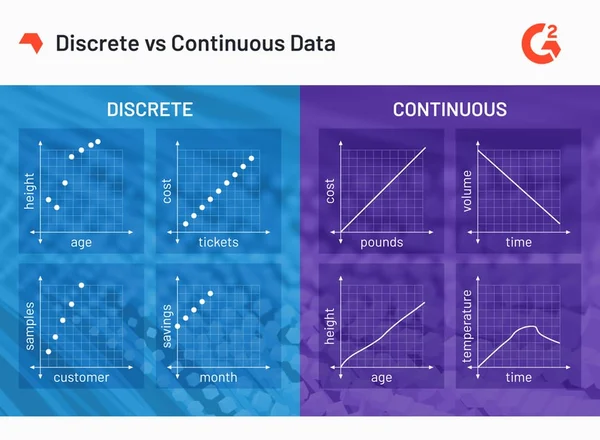


**Step 3**
Look at the plot for left and right sensor values, what do you see? Can you verify the 70 ms cycle time? 




**step4**
Can you use these plots to estimate velocity accurately?

**Task 4: Measurement Data analysis and interpretation**

**Step 1** 
Analyze the measured data with an eye on the possibility of compensating for the possible errors.



**Step 2**
 Implement some strategies to calibrate KITT.

```{note}{Bonus Tasks - Optional extension} Click to Show

Tip: It is advisable to store all the old distance data in a list inside the KITT class. This will be convenient during the final challenge, where the route planning might need old measurements to determine the position of objects. It will also help with characterizing the distance sensors. A good way of doing this is by initializing an empty list in the __init__ phase. Then, every time the sensor is read, you append this list with [time, left_dist, right_dist].

```


## Mid-term assessment 2.1 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your assigned TA. After you pass this assessment, you are ready to document your results in your midterm report. For this Module, you would include a chapter that covers the above tasks (using independently-readable text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made (i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before you discuss results and derive conclusions. Review the guidelines for more information. Include the corresponding code in an Appendix. Remember to document your code, using comments to define input/output variables of functions and to explain the logic and any modifications made. Your completed script will be crucial for the upcoming challenges, contributing to the overall autonomous driving system.

## Delay estimation code (NEW)

In [13]:
import serial
import time
import matplotlib . pyplot as plt
port = 'COM3 '
baudrate = 115200
serial = serial . Serial ( port , baudrate , rtscts = True )
elapsed_times = [] # List to store elapsed times
for _ in range (1000) :
start_time = time . time () # Record the start time
serial . write (b'S\n')
status = serial . read_until (b'\ x04 ')
end_time = time . time () # Record the end time
elapsed_time = end_time - start_time
elapsed_times . append ( elapsed_time )

IndentationError: expected an indented block after 'for' statement on line 8 (2968534848.py, line 9)

## Delay plot and statistical (NEW)

In [ ]:
plt . hist ( elapsed_times , bins =50 , color = 'skyblue ', edgecolor ='black ')
plt . xlabel ('Delay ␣ Time ␣( seconds )')
plt . ylabel ('Frequency ')
plt . title (' Distribution ␣of␣ Delay ␣ Time ␣ for ␣ Status ␣ Retrieval ')
plt . show ()

## Dynamic measurment (NEW)


In [ ]:

# A code to plot the Dynamic measuremnt

## The Microphones

Four microphones of the field are installed around its corners, and a fifth microphone is placed between two of the microphones at the edge of the field, at a level higher than the other four. These microphones, along with the beacon atop KITT, will be used to locate KITT within the field (chapter 5 ??@B update).

The appropriate sound card driver must be used to use the microphone array. The soundcard used in EPO-4 is a PreSonus AudioBox 1818VSL. On Linux, OSX (except the ARM version), and Windows 11, the sound card works out of the box. On Windows 10, it is necessary to install [ASIO4ALL](https://www.asio4all.org/) and a build of [PyAudio](https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyaudio) compiled with ASIO support. If you use the Pipfile provided on Brightspace, the correct version of PyAudio should already be installed, but you still need to install ASIO4ALL manually.

A typical laptop will have many possible audio devices, for example the built-in microphone, a Bluetooth headset, and the AudioBox 1818VSL used in EPO-4. To initialize the microphone array, the correct audio device should be specified. This short script will list the index and names of all audio devices visible to PyAudio.

In [ ]:
# (??@B change this to a better location)
%pip install -r requirements.txt
%pip install keyboard
%pip install pyaudio # @Mano @Mehrdad version

In [ ]:
import matplotlib
import numpy
import serial
import keyboard
import scipy
import statsmodels
import ipywidgets
import pyaudio
import tkinter as tk

In [ ]:

import pyaudio
pyaudio_handle = pyaudio.PyAudio()
for i in range(pyaudio_handle.get_device_count()):
    device_info = pyaudio_handle.get_device_info_by_index(i)
    print(i, device_info['name'])



```{important} Click to Show

On Windows 10, make sure to use the audio device index that has ASIO in the name. Other audio devices may be using the legacy MME or WDM Windows drivers, which may not support more than 2 synchronous
audio channels.

```

The microphone array must first be initialized. When doing so, the sampling frequency that will be used must be specified. This sampling frequency will either be 48 kHz or 44.1 kHz, depending on the type of audio device ( This should be more clear). Initializing the microphone array at device index `device_index` with a sampling frequency of `Fs` is done as, 


In [ ]:
# From the list of devices, add the desired index and the appropriate Fs value for the same.

stream = pyaudio_handle.open(input_device_index=device_index,
                            channels=5,
                            format=pyaudio.paInt16,
                            rate=Fs,
                            input=True)


To make a recording, the length of the recording must be specified. This must be specified as the number of audio frames to be recorded. The result will be a *bytes* object. Each audio frame will contain 5 samples, one for each microphone. Each sample contains 2 bytes, since we specified 16-bit audio. So, the return value of recording N frames is 10N bytes. To get a recording of N frames, one can run the
following command:


In [ ]:
samples = stream.read(N)

# To convert it into a numpy array
import numpy as np
data = np.frombuffer(samples, dtype='int16')

At this point, the microphone data is interleaved: data[0] contains the first sample of microphone 0, data[1] contains the first sample of microphone 1, data[2] contains the first sample of microphone 2, and so on until data[5] contains the second sample of microphone 0. Table 4.1 explains the concept more visually. This interleaved data stream should be deinterleaved into 5 streams, one for each microphone.

| data[0]      | data[1]      | data[2]      | data[3]      | data[4]      | data[5]      | data[6]      | data[7]      | ... |
|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|-----|
| mic 0        | mic 1        | mic 2        | mic 3        | mic 4        | mic 0        | mic 1        | mic 2        | ... |
| frame 0      | frame 0      | frame 0      | frame 0      | frame 0      | frame 1      | frame 1      | frame 1      | ... |


```{admonition} 

You may be familiar with the Matplotlib Python module, which can be used to plot the audio data received from the microphones. Matplotlib produces great-looking publication-ready figures. But drawing these plots can be slow. If you want to plot audio data in real time, consider using a more low-level GUI library such as PyGame or Pyglet and trade off beauty for speed. That said, Matplotlib supports some real-time features, such as animations. Just be aware that Matplotlib is not the only solution.

```

**Lab rules regarding the microphone array:** Many groups will be using the same setup, and to avoid
making other groups crazy (?), you are not allowed to rearrange the microphone connectors. Please also
don’t touch the volume settings. If these need to be adjusted, contact a TA.




## Microphone Recording Assignment 

The final part of communicating with KITT is using the 5 microphones. This will form an important part of the final challenge, a good implementation is thus essential. Again, you should add a method like `record` into the KITT class, with an input N. This should turn on the beacon, make a recording of N sec, deconvolve the recording into its separate channels, store it for later processing, and turn off the beacon. Make a function to visualize the recordings; this will prove valuable in debugging. (?? @Mano already include this in the the kitt class, encomment and complete? also add the simulator to check? both functions)

### Assignment


**Task 1** 

**Step 1** Initialize the microphone array and record one of your team members clapping near the microphones one after another. 



**Step 2** Separate the data stream of each microphone from the interleaved data. 



**Step 3** Plot the data of all five channels, and identify which channel of your recording represents which microphone.

In [ ]:
## @MANO and @Mehrdad, shall we add a block of code here so that they can complete for recording the sound?
# should we also add the functions to kitt class and provide the structure here?
# we can also organixe the codes from other parts together and organize them.

**Task 2**

**Step 1** Turn on KITT’s beacon and record your results. Can you see the waveform of the transmission?




**Step 2** Compare the waveform of the recording to an ideal OOK of your code. 




**Step 3** What can you see and what do you infer from this?



**Task 3**

Repeat the setup of Task 2, putting KITT nearer to one microphone than to others. Can you derive from the waveforms near which microphone KITT was placed? Show the plots you made and discuss your results and conclusions derived from them.




*Bonus Tasks - Optional*

- See if you can automate selecting the correct PyAudio device index. The correct device index changes from one computer to another and can sometimes even change on the same computer after a reboot. So, it is worth your time to make a program that can automatically select the right device index.
- Implement start-up sanity checks: some process which you can run after you arrive at the test field, so that you can quickly check the microphone connections and audio levels.
- Explore PyAudio’s callback mode. This manual describes what is called ‘blocking mode’. The stream.read() function will block your program until the requested number of frames has been received from the sound card. You can instead specify a callback function to process new audio frames as they arrive. If done carefully, this will allow your program to respond faster to new microphone samples, and enable you to drive while recording. You can read more about call-back mode in the official [PyAudio documentation](https://people.csail.mit.edu/hubert/pyaudio/docs/)




### Mid-term assessment 2.2 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your
assigned TA. After you pass this assessment, you are ready to document your results in your midterm
report.

For this Module, you would include a chapter that covers the above tasks (using independently-readable
text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made
(i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before
you discuss results and derive any conclusions. Be sure to answer the questions posed along with the
plots (using independently-readable text).

Include the corresponding code in an Appendix. Remember to document your code, using comments
to define input/output variables of functions and to explain the logic and any modifications made. Your
completed script will be crucial for the upcoming challenges, contributing to the overall autonomous
driving system.

This concludes the mid-term assignments related to communication with KITT. After the mid-term, you
must integrate this module with the localization module created by your colleagues. Take into account
that integrating is often harder than originally anticipated, e.g. your code has to run in parallel, and you
have to worry about timing aspects. Hopefully, using the KITT class will provide you with a sturdy and
flexible framework to continue your work towards the final challenge


FAQ



**What is the beam angel ?**

The beam angle of a sensor refers to how wide the sensor's detection area is. It determines how much space the sensor can cover when it sends out signals (like sound or light) to detect objects.

To determine the beam angle of ultrasonic sensors mounted in front of the car, you have multiple options: 

1. **Check the Sensor Datasheet**: The easiest way or at least a way to get some idea to determine the beam angle is to refer to the manufacturer's datasheet for your specific ultrasonic sensor. The datasheet will typically provide the beam angle, often around 15 to 30 degrees for common ultrasonic sensors. But keep in mind that is for a single sensor and not the current set up ! 

2. **Experimental Determination for KIIT**:
   - **Measure Detection Width**: Place a flat object (like a wall) at a fixed distance in front of the sensor (e.g., 1 meter).
   - **Move the Object**: Move the object left and right to determine the points where the sensor stops detecting the object.
   - **Calculate the Angle**: Measure the distance between these two points (detection width) and the distance from the sensor to the object. You may use the following formula:

   
     $$\
     \text{Beam Angle} = 2 \times \arctan\left(\frac{\text{Detection Width}/2}{\text{Distance to Object}}\right)
     \
   - This calculation will give you the beam angle in degrees.$$


   **Here comes a picture** 


**I see random numbers from sensors for large distances is my sensor damaged ?**

During experiments, you may occasionally receive random or unexpected data from the sensors. This can occur not only when the sensors are operating outside their effective range but also at times when they are within range. Several factors (consider what they might be?) can cause ultrasonic sensors to produce inaccurate readings. Additionally, since there are two sensors—one on the left and one on the right—they might produce different, completly different readings.


**Are the measuremnts done from ultra sonic sesnors on the left and the right side excatly at the same time ?**

If you closely observe the blinking of the small LEDs on the Ultrasonic board on the car, you might notice that they turn on and off alternately. This indicates a slight time difference in the sensor measurements. While you don't necessarily need to account for this, as other sources of inaccuracy are more apparent, this delay is also noticeable and can be measured.

**When I try to plot the distance it seems that numbers on the axis of the plot are not in order or I have some distances shown two times . There is nothing wrong with my plots and the python code runs. What could be the issue ?**

If you notice that some numbers are repeated or that the sequence of numbers on the axis seems incorrect, review your data extraction process. Ensure that you are printing the numbers as floats rather than characters!